In [1]:
import os
from dotenv import find_dotenv, load_dotenv
from pathlib import Path
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import DepthwiseConv2D

absProjectDir = Path(os.getcwd()).resolve().parents[0]
projectDir = os.path.relpath(absProjectDir,os.curdir)
load_dotenv(find_dotenv())

trainDfPath = os.path.join(projectDir, os.environ.get("REF_PROC_TRAIN_DF"))
testDfPath = os.path.join(projectDir, os.environ.get("REF_PROC_TEST_DF"))
testOrigDir = os.path.join(projectDir, os.environ.get("PROC_TEST_ORIG_DIR"))
testAugmDir = os.path.join(projectDir, os.environ.get("PROC_TEST_AUG_DIR"))
trainOrigDir = os.path.join(projectDir, os.environ.get("PROC_TRAIN_ORIG_DIR"))
trainAugmDir = os.path.join(projectDir, os.environ.get("PROC_TRAIN_AUG_DIR"))
testRootDir = os.path.commonpath([testOrigDir, testAugmDir])
trainRootDir = os.path.commonpath([trainOrigDir, trainAugmDir])
modelDir = os.path.join(projectDir, os.environ.get("MODEL_DIR"))

sys.path.append(os.path.join(projectDir,'src/data'))
sys.path.append(os.path.join(projectDir,'src/models'))
import imggen as imgen
from customlayer import DepthWiseConvBatchNorm
from customlayer import ConvBatchNorm
from customlayer import InceptionType
from customlayer import CustomInceptionFactory

from basemodel import BaseModel
from basemodel import DepthWiseConvModel1
from basemodel import ConvModel1
from basemodel import InterceptionModelV1
from basemodel import InterceptionModelV2
from basemodel import StemDecorator
from basemodel import StemDecoratorConv
from basemodel import StemDecoratorDepthWiseConv

C:\Users\PLDD\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [22]:
import tensorflow as tf
import numpy as np
import cv2

class Transformation(object):
    def __init__(self):
        pass
    def __call__(self,image):
        return image

class Resize(Transformation):
    '''
        method - one of the tf.image.ResizeMethod
    '''
    def __init__(self, size = None, method = tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio = False, antialias = False):
        super().__init__()
        self.method = method
        self.preserve_aspect_ratio = preserve_aspect_ratio
        self.antialias = antialias
        self.size = size
    def __call__(self,image = None):
        if self.size is None or image is None:
            return super().__call__(image)
        return tf.image.resize(image, self.size, method=self.method, 
                               preserve_aspect_ratio=self.preserve_aspect_ratio, 
                               antialias=self.antialias, name=None).numpy()
class Cropp(Transformation):
    def __init__(self, tolerance = None):
        super().__init__()
        self.tolerance = tolerance
    def __call__(self,image = None):
        if image is None or self.tolerance is None:
            return super().__call__(image)
        return self.__cropImage__(image)
    def __cropImage__(self, image):
        grayImage = tf.image.rgb_to_grayscale(image)
        mask = tf.greater(grayImage, self.tolerance)
        rows = tf.reshape(tf.reduce_any(mask,1), (-1,1))
        r_sz = tf.reduce_sum(tf.cast(rows,tf.int32));
        cols = tf.reshape(tf.reduce_any(mask,0),(1,-1))
        c_sz = tf.reduce_sum(tf.cast(cols,tf.int32))
        if c_sz == 0 or r_sz == 0:
            return image
        mask = tf.logical_and(rows,cols)
        newImage = []
        for i in range(3):
            newImage.append(tf.reshape(tf.boolean_mask(image[:,:,i],mask),(r_sz,c_sz)))
        return tf.stack(newImage,axis = 2).numpy()
    
class Sharppen(Transformation):
    def __init__(self, sigma = None):
        super().__init__()
        self.sigma = sigma
    def __call__(self, image = None):
        if image is None or self.sigma is None:
            return super().__call__(image)
        img = cv2.addWeighted ( image,4, cv2.GaussianBlur( image, (0,0) , self.sigma) ,-4 ,128)
        return img
    
class CircleMask(Transformation):
    def __init__(self):
        super().__init__()
    def __call__(self,image):
        if image is None:
            return super().__call__(image)
        height, width, depth = image.shape    
        x = int(width/2)
        y = int(height/2)
        r = np.amin((x,y))
        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        return cv2.bitwise_and(image, image, mask=circle_img)

class AddGauseNoise(Transformation):
    def __init__(self,supperSigma = 1):
        super().__init__()
        self.SupperSigma = supperSigma
        
    def __call__(self, image):
        if image is None:
            return super().__call__(image)
        sigmav = np.random.choice(self.SupperSigma, 3)
        noise = np.random.normal(0,sigmav,image.shape)
        return np.clip(noise + image,0.,255.)

class RandomVisualEffect(Transformation):
    def __init__(self):
        super().__init__()
        self.rot = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE,cv2.ROTATE_180]
    
    def __call__(self, image):
        if image is None:
            return super().__call__(image)
        rix = np.random.choice(3,1)[0]
        image = cv2.rotate(image,self.rot[rix])
        image = tf.image.adjust_contrast(image, 1.0 + 2.0 * np.random.random())
        #image = tf.image.random_hue(image,0.5)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        return image.numpy()
    
class Pipe(Transformation):
    def __init__(self,trans = None):
        super().__init__()
        self.trans = trans
    def __call__(self,image):
        if self.trans is None or image is None:
            return super().__call__(image)
        for tr in self.trans:
            image = tr(image)
        return image

In [23]:
import cv2
import os
import matplotlib.pyplot as plt
import imgtrans as tr

class ImagePreprocessing(object):
    def __init__(self, transforms = tr.Transformation()):
        self.transforms = transforms
        self.oimg = None
        self.timg = None
        
    def __call__(self,image):
        self.oimg = image
        self.timg = self.transforms(self.oimg)
        if self.timg is not None:
            self.timg = self.timg.astype('uint8')
        return self.timg
    
    def CompareImages(self):
        fig = plt.figure(figsize=(16,16))
        fig.add_subplot(1,2,1)
        plt.imshow(self.oimg)
        fig.add_subplot(1,2,2)
        plt.imshow(self.timg)

    def SaveModifiedImage(self, path):
        cv2.imwrite(path,self.timg)

    def LoadImage(path):
        if os.path.isfile(path):
            return cv2.imread(path)
        return None

def PreprocessImage(cropTol = 7, sigma = 32):
    cm = tr.CircleMask()
    crop = tr.Cropp(cropTol)
    resize = tr.Resize((224,224))
    sharp = tr.Sharppen(sigma)
    return ImagePreprocessing(tr.Pipe([cm, crop, sharp, resize]))

def Augmentation(sigma = 16):
    visEffects = tr.RandomVisualEffect()
    gaussNoise = tr.AddGauseNoise(sigma)
    return ImagePreprocessing(tr.Pipe([visEffects,gaussNoise]))

In [8]:
p1 = r'C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\APTOS\data\raw\train_images\00b74780d31d.png'
img1 = ImagePreprocessing.LoadImage(p1)
p2 = r'C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\APTOS\data\raw\train_images\00a8624548a9.png'
img2 = ImagePreprocessing.LoadImage(p2)

In [24]:
obj1 = PreprocessImage()
obj2 = Augmentation()

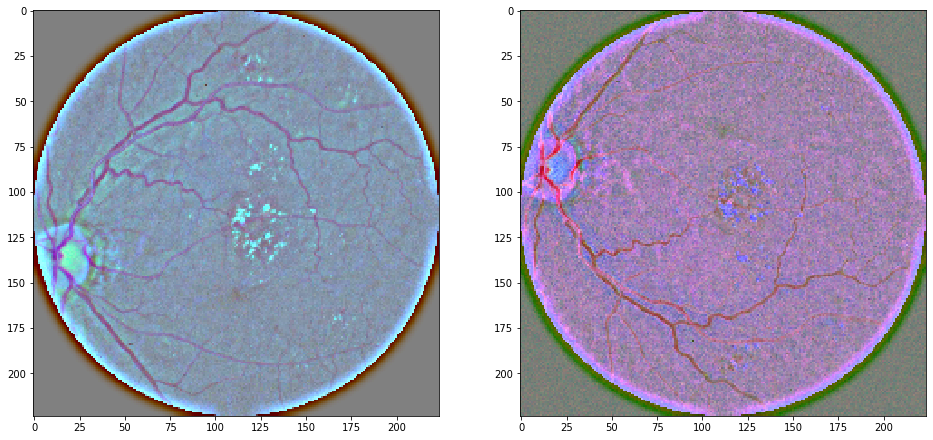

In [25]:
obj2(obj1(img2))
obj2.CompareImages()

In [26]:
trgen = imgen.Generator(trainDfPath, trainRootDir, (224,224))
trgen.SetDataFrameForGeneration([[2],[3,4]],[[2048],[1024,1024]])
train_set = trgen.GetGenerator(bs = 64)

tsgen = imgen.Generator(testDfPath,testRootDir, (224,224))
tsgen.SetDataFrameForGeneration([[2],[3,4]], [[1024],[512, 512]])
test_set = tsgen.GetGenerator(bs = 32)

evalgen = imgen.Generator(testDfPath,testRootDir, (224,224))
evalgen.SetDataFrameForGeneration([[2],[3]], [[512],[512]])
eval_set = tsgen.GetGenerator(bs = 1024)

Found 4096 validated image filenames belonging to 2 classes.
Found 2048 validated image filenames belonging to 2 classes.
Found 2048 validated image filenames belonging to 2 classes.


In [ ]:
def SaveModel(model,name,modelDir):
    path = os.path.join(modelDir,name)
    for suf in [''] + [str(i) for i in range(256)]:
        modified_path = path + suf
        if not os.path.exists(modified_path):
            os.makedirs(modified_path)
            path = modified_path
            break
    model.save(path)
    return path

In [27]:
model1 = DepthWiseConvModel1()
model2 = ConvModel1()

In [ ]:
lrs = [0.001, 0.0007, 0.0005, 0.0003, 0.0001]
nn = [10,20,30,40,10000]
jj = 0
convmod = ConvModel1(learn_rate = lrs[jj], units = 1024, L2 = 0.0001)
model = convmod.Create()
for i in range(60):
    print("Step - {}".format(i))
    if i > nn[jj]:
        jj += 1
        model.lr = lrs[jj]
    history = model.fit(train_set,steps_per_epoch = 64,
                        epochs = 1, validation_data = test_set,validation_steps = 64)

Model ConvModel1_F32_U1024_LR001_L20001_LCnt6 is built
Step - 0
Train for 64 steps, validate for 64 steps
64/64 [==============================] - 683s 11s/step - loss: 0.9792 - accuracy: 0.5737 - val_loss: 0.9311 - val_accuracy: 0.5000
Step - 1
Train for 64 steps, validate for 64 steps
64/64 [==============================] - 635s 10s/step - loss: 0.7864 - accuracy: 0.5881 - val_loss: 1.3631 - val_accuracy: 0.5000
Step - 2
Train for 64 steps, validate for 64 steps
64/64 [==============================] - 640s 10s/step - loss: 0.7606 - accuracy: 0.5950 - val_loss: 0.9971 - val_accuracy: 0.5000
Step - 3
Train for 64 steps, validate for 64 steps
24/64 [==========>...................] - ETA: 5:55 - loss: 0.7582 - accuracy: 0.5794

In [34]:
0.001, 0

0.0005

In [ ]:
histories = dict()
for obj in [model2]:
    for unit in [1024]:
        for lr in [0.0001, 0.0005, 0.001]:
            obj.units = unit
            obj.learn_rate = lr
            model = obj.Create()
            history = model.fit(train_set,
                 steps_per_epoch = 64,
                 epochs = 90, validation_data = test_set,validation_steps = 64)
            SaveModel(model, model.name, modelDir)
            histories[model.name] = history    

In [28]:
model2.Create().summary()

Model ConvModel1_F32_U512_LR0001_LCnt6 is built
Model: "ConvModel1_F32_U512_LR0001_LCnt6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_batch_norm (ConvBatchNo (None, 224, 224, 32)      1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv_batch_norm_1 (ConvBatch (None, 112, 112, 64)      18752     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv_batch_norm_2 (ConvBatch (None, 56, 56, 128)       74368     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
____________________________________________________

In [ ]:
intercept = StemDecoratorConv(conv_layer_cnt = 2, intercept_module = InterceptionModelV2())
model = intercept.Create()

In [ ]:
hist = model.fit(train_set,
                 steps_per_epoch = 128 / 8,
                 epochs = 1, validation_data = test_set,validation_steps = 2)

In [ ]:
m1 = ConvModel1()
model1 = m1.Create()
model1.summary()

In [ ]:
m2 = DepthWiseConvModel1()
model2 = m2.Create()
model2.summary()